# Truffle Pig: Conversion Prediction Model

**Project:** Proof-of-Concept for Truffle Pig
**Objective:** Train an XGBoost classifier to predict the likelihood of a user session converting into an order. The model's performance will be used to power a 'Lift Forecast' feature in the final Streamlit dashboard.

**Methodology:**
1.  **Load & Merge Data:** Load the `sessions.csv`, `campaigns.csv`, and `orders.csv` files.
2.  **Feature Engineering:** Create new features from the raw data to improve model performance.
3.  **Data Splitting:** Split the data chronologically into three sets: 70% for training, 15% for hyperparameter tuning, and 15% for final testing.
4.  **Hyperparameter Tuning:** Use Optuna to find the best hyperparameters for the XGBoost model on the tuning set.
5.  **Final Evaluation:** Train the model with the best parameters on the full training set and evaluate its performance on the unseen test set, targeting an AUC-ROC score of ≥ 0.85.
6.  **Save Artifacts:** Save the trained model and feature list for use in the Streamlit dashboard.

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Load and Prepare Data

In [14]:
# Load the mock data files
sessions_df = pd.read_csv('sessions.csv')
campaigns_df = pd.read_csv('campaigns.csv')
orders_df = pd.read_csv('orders.csv') # Load orders for context, not features

# Convert date columns to datetime objects
sessions_df['session_start'] = pd.to_datetime(sessions_df['session_start'])
campaigns_df['start_date'] = pd.to_datetime(campaigns_df['start_date'])

# Merge sessions with campaign data
data_df = pd.merge(sessions_df, campaigns_df, on='campaign_id', how='left')

print("Data loaded and merged successfully.")
print(f"Total records: {len(data_df)}")
data_df.head()

Data loaded and merged successfully.
Total records: 200000


,session_id,user_id,session_start,utm_source,utm_medium,campaign_id,converted,campaign_name,start_date,spend,creative_format,creative_theme,effectiveness_tier
0,session_1,user_2867,2023-04-20 10:39:11,direct,cpc,campaign_44,0,Campaign 44 (Medium),2023-01-10,24544,lifestyle,Promo / Sale,Medium
1,session_2,user_5480,2023-05-23 12:06:27,facebook,cpc,campaign_44,0,Campaign 44 (Medium),2023-01-10,24544,lifestyle,Promo / Sale,Medium
2,session_3,user_41267,2023-10-10 16:51:00,google,cpc,campaign_32,0,Campaign 32 (High),2023-05-26,18855,UGC,Evergreen,High
3,session_4,user_28563,2023-11-18 09:55:48,google,organic,campaign_22,0,Campaign 22 (Medium),2023-08-05,2097,static,Evergreen,Medium
4,session_5,user_48005,2023-04-02 06:20:24,direct,cpc,campaign_4,1,Campaign 4 (Medium),2023-08-03,18547,UGC,Evergreen,Medium


## 2. Feature Engineering

Create new features to help the model learn patterns. This includes time-based features and one-hot encoding for categorical variables.

In [15]:
# Time-based features
data_df['hour_of_day'] = data_df['session_start'].dt.hour
data_df['day_of_week'] = data_df['session_start'].dt.dayofweek # Monday=0, Sunday=6
data_df['month'] = data_df['session_start'].dt.month

# One-hot encode categorical features
categorical_cols = ['utm_source', 'utm_medium', 'creative_format', 'creative_theme', 'effectiveness_tier']
data_df = pd.get_dummies(data_df, columns=categorical_cols, dummy_na=True)

# Fill NaN values for spend (for sessions with no campaign)
data_df['spend'] = data_df['spend'].fillna(0)

print("Feature engineering complete.")

Feature engineering complete.


## 3. Data Splitting (70/15/15)

Split the data chronologically to prevent data leakage. The first 70% of the data will be for training, the next 15% for tuning, and the final 15% for testing.

In [16]:
# Sort data by time to ensure a proper chronological split
data_df.sort_values('session_start', inplace=True)

# Define features (X) and target (y)
target = 'converted'
# We exclude identifiers, dates, and the target itself.
# 'spend' IS included as a feature.
features_to_exclude = ['session_id', 'user_id', 'session_start', 'campaign_id', 'campaign_name', 'start_date', 'target']
features = [col for col in data_df.columns if col not in features_to_exclude and col != target]

X = data_df[features]
y = data_df[target]

# Calculate split points
train_size = int(0.7 * len(data_df))
tune_size = int(0.15 * len(data_df))

X_train, y_train = X[:train_size], y[:train_size]
X_tune, y_tune = X[train_size:train_size + tune_size], y[train_size:train_size + tune_size]
X_test, y_test = X[train_size + tune_size:], y[train_size + tune_size:]

print(f"Train set size: {len(X_train)}")
print(f"Tune set size:  {len(X_tune)}")
print(f"Test set size:  {len(X_test)}")

Train set size: 140000
Tune set size:  30000
Test set size:  30000


## 4. Hyperparameter Tuning with Optuna

In [17]:
def objective(trial):
    """Objective function for Optuna to maximize AUC-ROC."""
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0)
    }
    
    model = xgb.XGBClassifier(**params)
    # FIX: Removed 'early_stopping_rounds' as it was causing a TypeError in the user's environment.
    # Optuna will still effectively manage the number of estimators.
    model.fit(X_train, y_train, eval_set=[(X_tune, y_tune)], verbose=False)
    
    preds = model.predict_proba(X_tune)[:, 1]
    auc = roc_auc_score(y_tune, preds)
    return auc

print("Starting hyperparameter tuning with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25) # Run 25 trials for speed

print("Tuning complete!")
print(f"Best AUC on tune set: {study.best_value:.4f}")
print("Best parameters found:")
best_params = study.best_params
print(best_params)

[I 2025-07-18 18:45:43,137] A new study created in memory with name: no-name-6d7e99b0-2587-4010-a981-9d93a7295240


Starting hyperparameter tuning with Optuna...


[I 2025-07-18 18:45:48,220] Trial 0 finished with value: 0.875824674463679 and parameters: {'n_estimators': 607, 'learning_rate': 0.053269436693662846, 'max_depth': 9, 'subsample': 0.8644472939856979, 'colsample_bytree': 0.9883739292554927, 'gamma': 0.4490994272094684}. Best is trial 0 with value: 0.875824674463679.
[I 2025-07-18 18:45:51,252] Trial 1 finished with value: 0.8893413354258336 and parameters: {'n_estimators': 525, 'learning_rate': 0.014910182728823704, 'max_depth': 9, 'subsample': 0.6688526154410447, 'colsample_bytree': 0.6909401559814629, 'gamma': 3.467366909029084}. Best is trial 1 with value: 0.8893413354258336.
[I 2025-07-18 18:45:53,756] Trial 2 finished with value: 0.8892537576673994 and parameters: {'n_estimators': 463, 'learning_rate': 0.03092876395138019, 'max_depth': 6, 'subsample': 0.8333882624810428, 'colsample_bytree': 0.6576925051639073, 'gamma': 2.688013746586233}. Best is trial 1 with value: 0.8893413354258336.
[I 2025-07-18 18:45:54,794] Trial 3 finished 

Tuning complete!
Best AUC on tune set: 0.8899
Best parameters found:
{'n_estimators': 954, 'learning_rate': 0.012203000019637917, 'max_depth': 5, 'subsample': 0.9129645309198726, 'colsample_bytree': 0.9572268912490842, 'gamma': 4.0686056081572}


## 5. Final Model Evaluation

/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:47:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Final Model Performance ---
AUC-ROC on Test Set: 0.8937


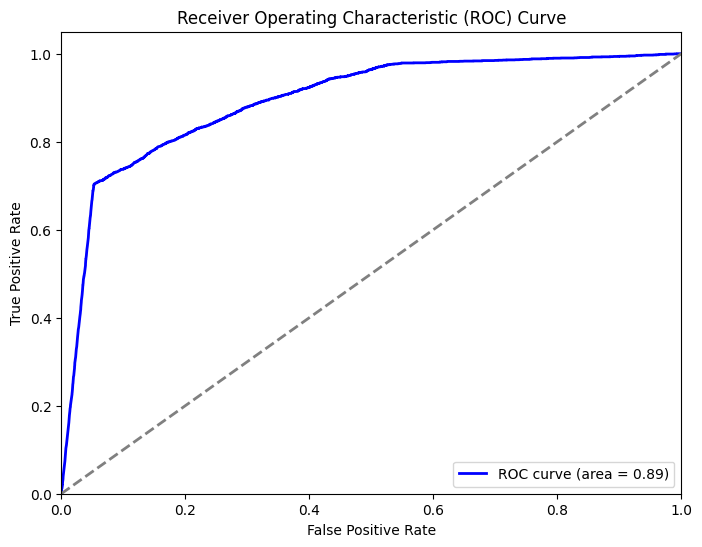

In [18]:
# Train the final model on the full training data using the best parameters
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)

# Combine train and tune sets for final training
X_train_full = pd.concat([X_train, X_tune])
y_train_full = pd.concat([y_train, y_tune])

final_model.fit(X_train_full, y_train_full, verbose=False)

# Evaluate on the unseen test set
test_preds = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_preds)

print(f"\n--- Final Model Performance ---")
print(f"AUC-ROC on Test Set: {test_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

This chart shows which factors the model considered most important when predicting conversions. This helps answer the client's question of *how* we are winning or losing.

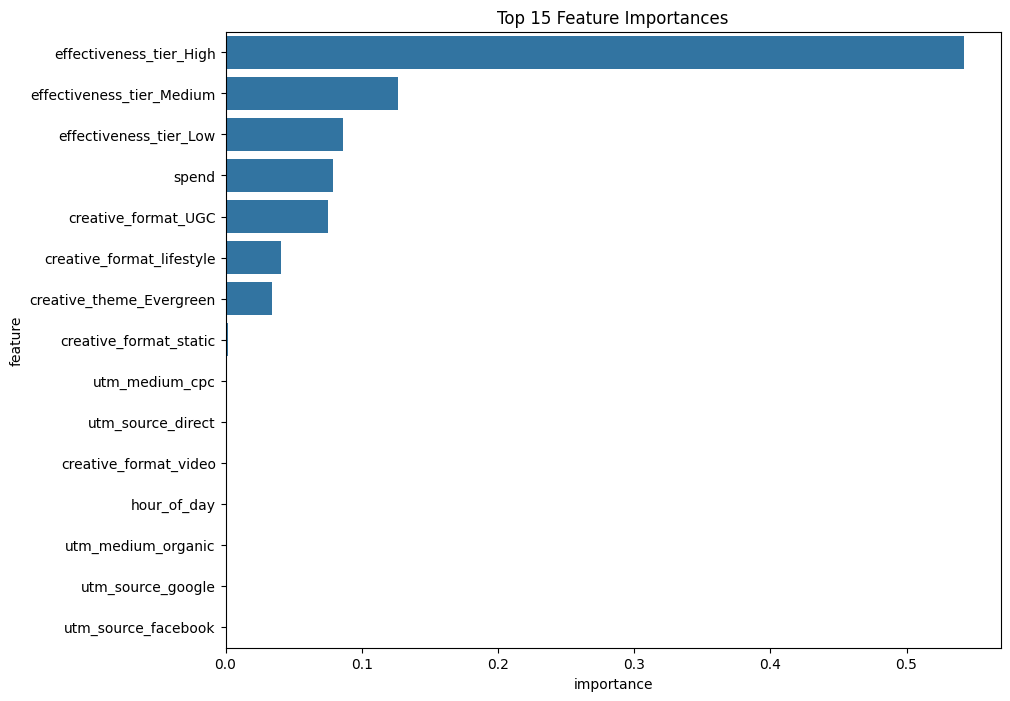

In [19]:
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.show()

## 6. Save Model and Features

Save the trained model and the list of features it was trained on. The Streamlit dashboard will load these files directly.

In [20]:
model_path = Path("conversion_model.joblib")
features_path = Path("model_features.joblib")

joblib.dump(final_model, model_path)
joblib.dump(features, features_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Features list saved to: {features_path}")

✅ Model saved to: conversion_model.joblib
✅ Features list saved to: model_features.joblib
